In [127]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Conv2D, MaxPool2D, UpSampling2D, Flatten, Dropout, BatchNormalization, Activation, Reshape, Conv2DTranspose, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# Metrics
import seaborn as sns

import pywt 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import scipy
import os
import numpy as np
project_seed=2023

In [87]:
len(data)

956

In [147]:
path1 = "Network class/cls1.mat"
path2 = "Network class/cls2.mat"
path3 = "Network class/cls3.mat"
scaler = StandardScaler()
data1 = scaler.fit_transform(scipy.io.loadmat(path1)["cls1"])
data2 =scaler.fit_transform( scipy.io.loadmat(path2)["cls2"])
data3 = scaler.fit_transform(scipy.io.loadmat(path3)["cls3"])
data4= scaler.fit_transform([np.random.normal(0, 1, size=61) for i in range(len(data1))])
data = np.concatenate((data1, data2, data3,data4), axis=0)
y = np.zeros((data.shape[0],4))
y[0:data1.shape[0],0] = 1
y[data1.shape[0]:data1.shape[0]+data2.shape[0],1] = 1
y[data1.shape[0]+data2.shape[0]:data1.shape[0]+data2.shape[0]+data3.shape[0],2] = 1
y[data1.shape[0]+data2.shape[0]+data3.shape[0]:,3] = 1


In [107]:
X_regression=np.array(data)
y_regression=np.array(np.argmax(y, axis=1))

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_regression, y_regression, test_size=0.3, random_state=project_seed)

### Logistic regression for classification

In [109]:
## Doing Logistic Regression
model = LogisticRegression(multi_class='multinomial', max_iter=10000,)
model.fit(X_train, y_train)

# Step : Prediction
predictions = model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, predictions):.2f}")
print(f"Recall: {recall_score(y_test, predictions, average='macro'):.2f}")
print(f"Precision: {precision_score(y_test, predictions, average='macro'):.2f}")
print(f"F1 Score: {f1_score(y_test, predictions, average='macro'):.2f}")



Accuracy: 0.48
Recall: 0.26
Precision: 0.33
F1 Score: 0.20


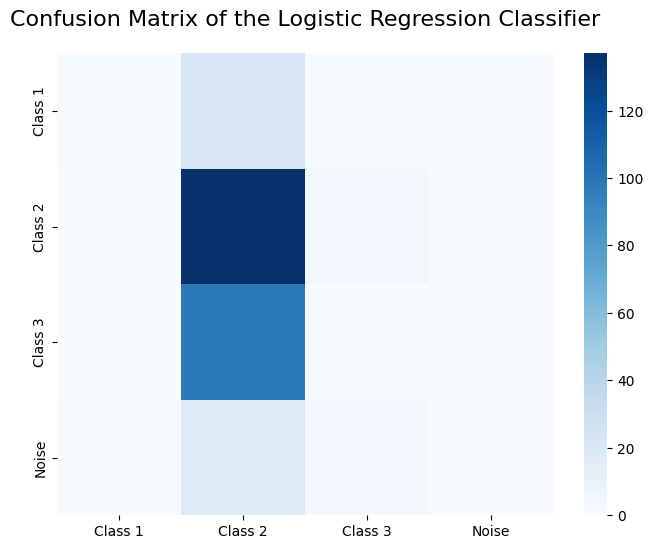

In [110]:

cf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=False, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Class 1', 'Class 2', 'Class 3', 'Noise'],
            yticklabels=['Class 1', 'Class 2', 'Class 3', 'Noise'])

# Add title
plt.title('Confusion Matrix of the Logistic Regression Classifier', fontsize=16, pad=20)

# Show the plot
plt.show()

### LSTM

In [113]:
# Transfoming data to be LSTM compatible
win_size=10
X=np.zeros((data.shape[0], data.shape[1]-win_size, win_size))
Y=[]
for j in range(data.shape[0]):
    for i in range(data.shape[1]-win_size):
        X[j, i, :] = data[j, i:i+win_size]
        Y.append(y[j])
Y=np.array(Y)
X=np.reshape(X, (data.shape[0]*(data.shape[1]-win_size), win_size))
Y=np.reshape(Y, (data.shape[0]*(data.shape[1]-win_size), 4))

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.6, random_state=project_seed)

In [116]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()

model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',  # Use categorical_crossentropy for multiclass classification
              optimizer=Adam(),
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=5, batch_size=6, validation_split=0.2, verbose=1)

Epoch 1/5
2601/2601 [==============================] - 26s 10ms/step - loss: 0.7380 - accuracy: 0.6396 - val_loss: 0.5295 - val_accuracy: 0.7639
Epoch 2/5
2601/2601 [==============================] - 25s 9ms/step - loss: 0.5350 - accuracy: 0.7512 - val_loss: 0.4887 - val_accuracy: 0.7665
Epoch 3/5
2601/2601 [==============================] - 24s 9ms/step - loss: 0.4959 - accuracy: 0.7772 - val_loss: 0.4629 - val_accuracy: 0.7939
Epoch 4/5
2601/2601 [==============================] - 24s 9ms/step - loss: 0.4628 - accuracy: 0.7894 - val_loss: 0.5003 - val_accuracy: 0.7660
Epoch 5/5
2601/2601 [==============================] - 23s 9ms/step - loss: 0.4634 - accuracy: 0.7983 - val_loss: 0.4398 - val_accuracy: 0.8018


610/610 [==============================] - 3s 5ms/step


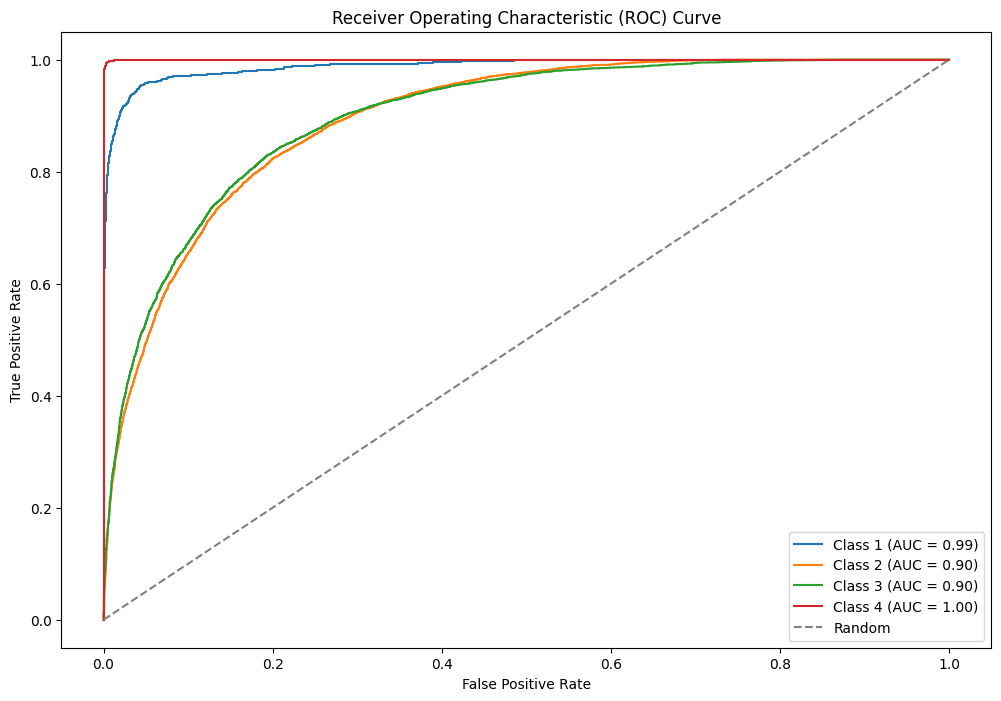

In [117]:
## Plot ROC curve
y_pred_prob = model.predict(X_train)

# Assuming y_train is one-hot encoded, convert it to integer labels
y_train_int = np.argmax(y_train, axis=1)
num_classes=4
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_int == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

# Plot the 50% line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


## Testing the model

In [98]:
# Testing the model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_pred = model.predict(X_test)


915/915 [==============================] - 5s 6ms/step


In [99]:
# Calculating precision and recall scores
print(f"Accuracy: {accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)):.2f}")
print(f"Recall: {recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'):.2f}")
print(f"Precision: {precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'):.2f}")
print(f"F1 Score: {f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'):.2f}")


Accuracy: 0.81
Recall: 0.84
Precision: 0.85
F1 Score: 0.84


In [61]:
len(y_test.argmax(axis=1))

29254

In [79]:
cf_matrix

array([[  1,  23,   0,   0],
       [  0, 137,   4,   0],
       [  0,  99,   0,   0],
       [  0,  15,   4,   4]])

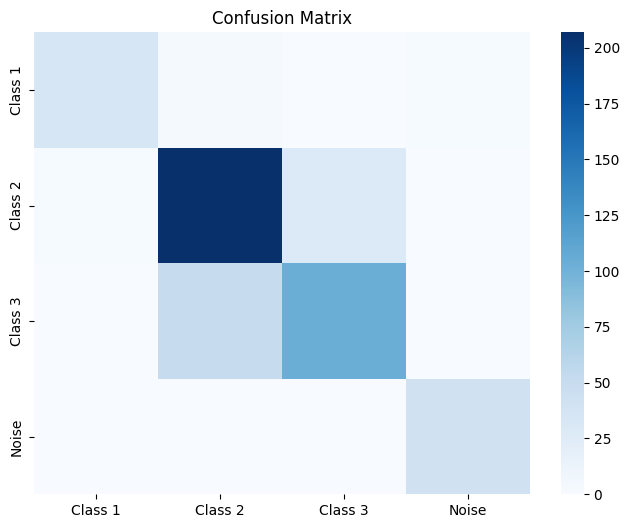

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))//61

plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=False, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Class 1', 'Class 2', 'Class 3', 'Noise'],
            yticklabels=['Class 1', 'Class 2', 'Class 3', 'Noise'])

# Add title
plt.title('Confusion Matrix')

# Show the plot
plt.show()



## Network class

In [ ]:
# Importing the data from Network signals
paths=[file for file in os.listdir("Network signals/") if file.endswith(".mat")]
data_network=[]
for path in paths:
    data_network.append(scipy.io.loadmat("Network signals/"+path)["s"])
data_network=np.squeeze(np.array(data_network))

In [ ]:
data_network.shape

(1000, 1478)

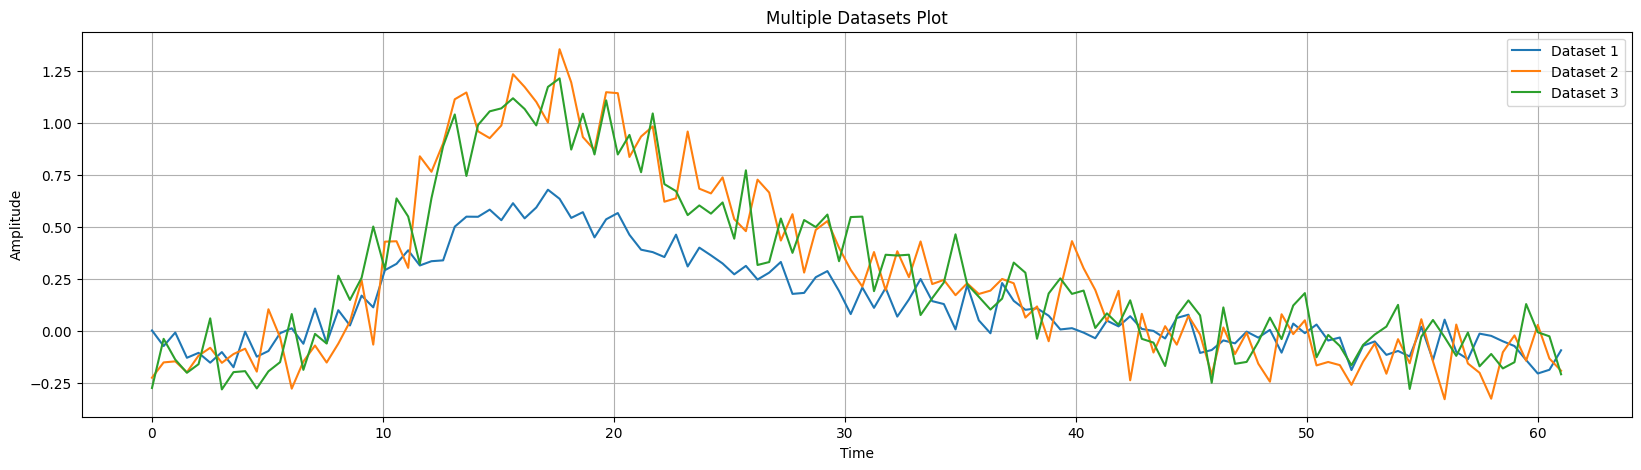

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5))
time_values = np.linspace(0, 61, len(data_network[0][00:2*61]))

for i, dataset in enumerate(data_network[560:563]):
    plt.plot(time_values, dataset[2*61:4*61], label=f'Dataset {i+1}')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Multiple Datasets Plot')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


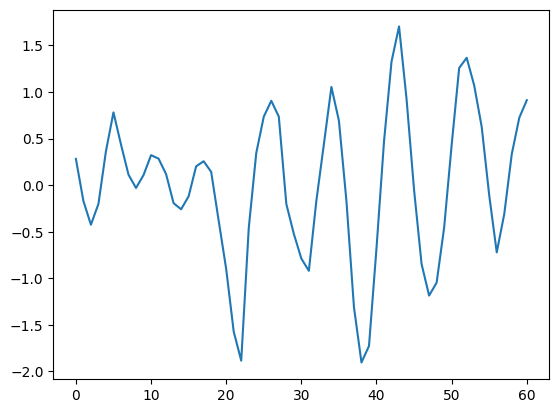

In [ ]:
plt.plot(data1[0])

## Wavelets

In [120]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'db1', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    return np.abs(coefficients)


In [148]:
wavelets_data = np.swapaxes(plot_wavelet(np.linspace(0, 60, 61), data, np.arange(1, 61), waveletname='cgau1'),1,0)
wavelets_data = wavelets_data.reshape(wavelets_data.shape[0], wavelets_data.shape[1], wavelets_data.shape[2], 1)
y_wavelets = np.zeros((data.shape[0],4))
y_wavelets[0:data1.shape[0],0] = 1
y_wavelets[data1.shape[0]:data1.shape[0]+data2.shape[0],1] = 1
y_wavelets[data1.shape[0]+data2.shape[0]:data1.shape[0]+data2.shape[0]+data3.shape[0],2] = 1
y_wavelets[data1.shape[0]+data2.shape[0]+data3.shape[0]:,3] = 1


In [150]:
X_train, X_test, y_train, y_test = train_test_split(wavelets_data, y_wavelets, test_size=0.2, random_state=42)


In [149]:
wavelets_data = np.swapaxes(plot_wavelet(np.linspace(0, 60, 61), data, np.arange(1, 61), waveletname='cgau1'),1,0)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(60, 61, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(4, activation='softmax'))


In [152]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

Epoch 1/10
20/20 [==============================] - 2s 52ms/step - loss: 0.4866 - accuracy: 0.8298 - val_loss: 0.4497 - val_accuracy: 0.8105
Epoch 2/10
20/20 [==============================] - 1s 47ms/step - loss: 0.4387 - accuracy: 0.8314 - val_loss: 0.4356 - val_accuracy: 0.9150
Epoch 3/10
20/20 [==============================] - 1s 47ms/step - loss: 0.3914 - accuracy: 0.8429 - val_loss: 0.3548 - val_accuracy: 0.9216
Epoch 4/10
20/20 [==============================] - 1s 47ms/step - loss: 0.3415 - accuracy: 0.8871 - val_loss: 0.5286 - val_accuracy: 0.8497
Epoch 5/10
20/20 [==============================] - 1s 47ms/step - loss: 0.3025 - accuracy: 0.8887 - val_loss: 0.2939 - val_accuracy: 0.9216
Epoch 6/10
20/20 [==============================] - 1s 47ms/step - loss: 0.2437 - accuracy: 0.9182 - val_loss: 0.3819 - val_accuracy: 0.8954
Epoch 7/10
20/20 [==============================] - 1s 48ms/step - loss: 0.2514 - accuracy: 0.9116 - val_loss: 0.2500 - val_accuracy: 0.9216
Epoch 8/10
20

In [156]:
y_pred = model.predict(X_test)

6/6 [==============================] - 0s 17ms/step


In [157]:
# Calculating precision and recall scores
print(f"Accuracy: {accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)):.2f}")
print(f"Recall: {recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'):.2f}")
print(f"Precision: {precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'):.2f}")
print(f"F1 Score: {f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'):.2f}")

Accuracy: 0.95
Recall: 0.97
Precision: 0.98
F1 Score: 0.97


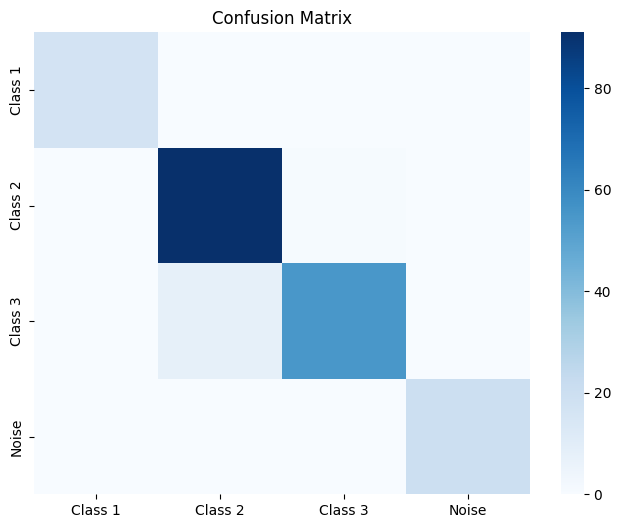

In [158]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=False, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Class 1', 'Class 2', 'Class 3', 'Noise'],
            yticklabels=['Class 1', 'Class 2', 'Class 3', 'Noise'])

# Add title
plt.title('Confusion Matrix')

# Show the plot
plt.show()


24/24 [==============================] - 1s 16ms/step


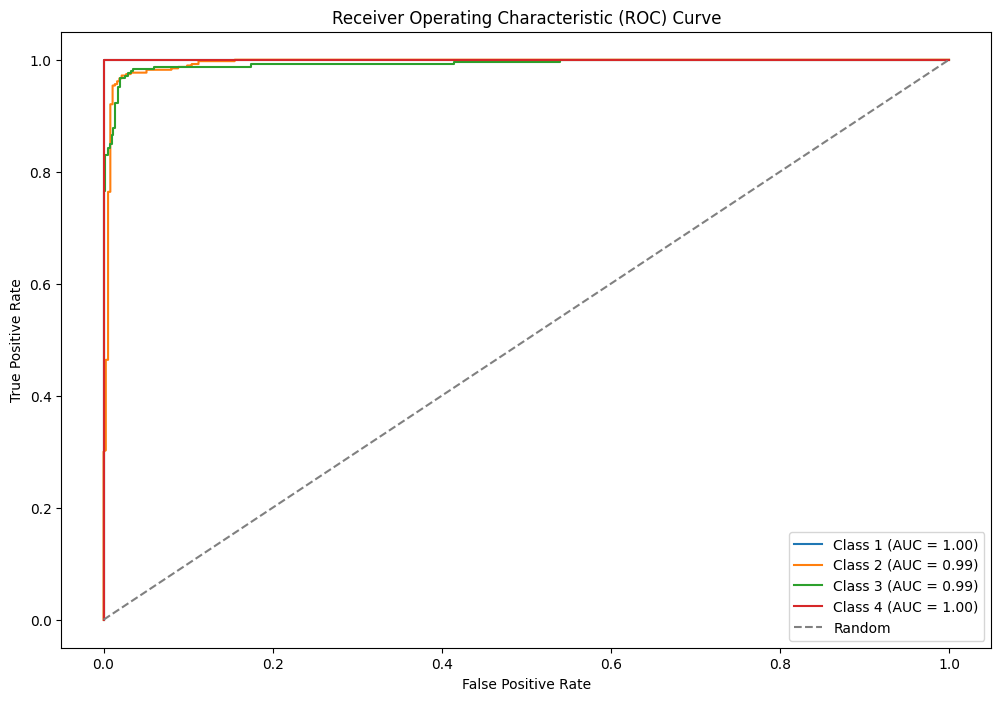

In [159]:
## Plot ROC curve
y_pred_prob = model.predict(X_train)

# Assuming y_train is one-hot encoded, convert it to integer labels
y_train_int = np.argmax(y_train, axis=1)
num_classes=4
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_int == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

# Plot the 50% line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()